In [ ]:
from keras import layers 
from keras import models 
from keras import optimizers 
from keras.preprocessing.image import ImageDataGenerator 
from keras.applications.vgg16 import VGG16
from keras.preprocessing import image
from keras.applications.imagenet_utils import preprocess_input
from keras.layers import Input, Flatten, Dense, Conv2D, ActivityRegularization
from keras.models import Model
import numpy as np
from keras import backend as k
import tensorflow as tf
from keras.applications import resnet50
import os 
import matplotlib.pyplot as plt

##Unzip the Cifar dataset 

In [ ]:
!p7zip -d Cifar4_SortedImages.7z 

/usr/bin/p7zip: cannot read Cifar4_SortedImages.7z


##Model Structure. 
####----> CNN layers:- 
These are typically used to reduce the dimensionality of the network. Features of a fully connected layer. Fully connected layers are placed before the classification output of a CNN and are used to flatten the results before classification.

####----> Max Pooling layers:-
Pooling layers are used to reduce the dimensions of the feature maps. Thus, it reduces the number of parameters to learn and the amount of computation performed in the network. The pooling layer summarises the features present in a region of the feature map generated by a convolution layer.

####----> Dense Layers :- 
Dense layers are used when association can exist among any feature to any other feature in data point.

####----> ReLu:-
ReLU is important because it does not saturate; the gradient is always high (equal to 1) if the neuron activates. As long as it is not a dead neuron, successive updates are fairly effective. ReLU is also very quick to evaluate.

####----> Softmax:- 
Softmax is very useful because it converts the scores to a normalized probability distribution, which can be displayed to a user or used as input to other systems. For this reason it is usual to append a softmax function as the final layer of the neural network.

In [ ]:
def MakeModel(weights_path=None):
    model = models.Sequential() 
    model.add(layers.Conv2D(64, (3, 3), activation='relu', input_shape=(32, 32, 3))) 
    model.add(layers.MaxPooling2D((2, 2))) 
    #-----------------------------------
    #-------Build your layers here -----
    model.add(layers.Conv2D(128, (3, 3), activation='relu', input_shape=(32, 32, 3))) 
    model.add(layers.MaxPooling2D((2, 2)))   
    model.add(layers.Dense(1024,activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(512,activation='relu'))
    model.add(layers.Dense(256,activation='tanh'))
    #-----------------------------------
    
    model.add(layers.Flatten()) 
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(512, activation='relu')) 
    model.add(layers.Dense(4, activation='softmax', name='output')) 
    #model.add(layers.Dense(1000, activation='softmax'))
    return model

###Calculating cross entropy loss function and we are using Adam optimizer to optimize our network over time.



In [ ]:
from keras.models import Model, load_model
from tensorflow.keras import regularizers

base_dir = 'Cifar4_SortedImages' 
train_dir = os.path.join(base_dir, 'train') 
validation_dir = os.path.join(base_dir, 'validation') 
test_dir = os.path.join(base_dir, 'test') 

model = MakeModel()

# Displaying a summary of the model 
model.summary() 

# Configuring our model for training 
# For a binary classification problem 
model.compile(loss='categorical_crossentropy', optimizer=optimizers.Adam(lr=0.0001), metrics=['accuracy']) 

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 30, 30, 64)        1792      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 13, 13, 128)       73856     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 6, 6, 128)         0         
_________________________________________________________________
dense (Dense)                (None, 6, 6, 1024)        132096    
_________________________________________________________________
dropout (Dropout)            (None, 6, 6, 1024)        0         
_________________________________________________________________
dense_1 (Dense)              (None, 6, 6, 512)         5

#Training 


In [ ]:

# Using ImageDataGenerator to read images from directories 
# all images will be rescaled by 1./255 
#train_datagen = ImageDataGenerator(rescale=1./255)  

#preprocess_input = resnet50.preprocess_input
train_datagen = ImageDataGenerator(
    rescale=1./255,
    preprocessing_function=preprocess_input
)

validation_datagen = ImageDataGenerator(rescale=1./255, preprocessing_function=preprocess_input) 
test_datagen = ImageDataGenerator(rescale=1./255, preprocessing_function=preprocess_input) 

train_generator = train_datagen.flow_from_directory( 
    train_dir, # this is the target directory 
    target_size=(32, 32),  
    batch_size=32,
    shuffle=True,
    class_mode = 'categorical') 
    # since we use categorical_crossentropy loss, we need categorical labels 
 
validation_generator = validation_datagen.flow_from_directory( 
    validation_dir, 
    target_size=(32, 32), 
    batch_size=32,
    shuffle=True,
    class_mode = 'categorical')

step_size_train=train_generator.n//train_generator.batch_size
step_size_val = validation_generator.samples // validation_generator.batch_size

from keras.callbacks import EarlyStopping, ModelCheckpoint

checkpointer = ModelCheckpoint(
		filepath='weights.h5',
		verbose=1, save_best_only=True	
	)

early_stopping = EarlyStopping(monitor='val_loss',patience=10)


# Fitting our model using a batch generator 
# Trains the model for a fixed number of epochs (iterations on a dataset). 
history = model.fit_generator( 
   train_generator, 
   steps_per_epoch=step_size_train, 
   epochs=10,  
   # callbacks=[checkpointer,early_stopping],
   validation_data=validation_generator, 
   validation_steps=step_size_val) 
 
 
# Evaluating the model - test on finalised model 
# Returns the loss value & metrics values for the model in test mode. 
test_generator = test_datagen.flow_from_directory( 
    test_dir, 
    target_size=(32, 32), 
    batch_size=32,
    shuffle=True,
    class_mode = 'categorical') 
 

step_size_test = test_generator.samples // test_generator.batch_size
# finally evaluate this model on the test data 
results = model.evaluate_generator( 
    test_generator, 
    steps=step_size_test) 
print('Final test accuracy:', (results[1]*100.0))

Found 15000 images belonging to 4 classes.
Found 3000 images belonging to 4 classes.
Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/10
468/468 [==============================] - 8s 17ms/step - loss: 1.1726 - accuracy: 0.4735 - val_loss: 1.0366 - val_accuracy: 0.5514
Epoch 2/10
468/468 [==============================] - 8s 17ms/step - loss: 0.9833 - accuracy: 0.5829 - val_loss: 0.9240 - val_accuracy: 0.6203
Epoch 3/10
468/468 [==============================] - 8s 17ms/step - loss: 0.9021 - accuracy: 0.6235 - val_loss: 0.9091 - val_accuracy: 0.6196
Epoch 4/10
468/468 [==============================] - 8s 18ms/step - loss: 0.8398 - accuracy: 0.6518 - val_loss: 0.8285 - val_accuracy: 0.6620
Epoch 5/10
468/468 [==============================] - 8s 17ms/step - loss: 0.7851 - accuracy: 0.6764 - val_loss: 0.8225 - val_accuracy: 0.6677
Epoch 6/10
468/468 [==============================] - 8s 17ms/step - loss: 0.7359 - accuracy: 0.6986 - val_loss: 0.7693 - va

#Plotting both Training versus Validation for Accuracy and Loss

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


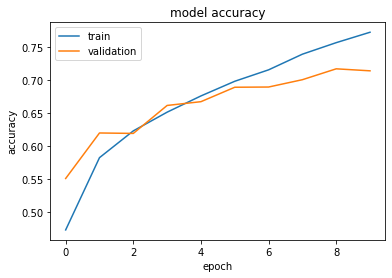

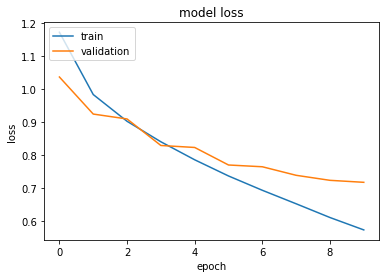

In [ ]:
print(history.history.keys())
#  "Accuracy"
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# "Loss"
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()